In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from pyramid.arima import auto_arima


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


from pandas_datareader.data import DataReader
from datetime import date

ModuleNotFoundError: No module named 'pandas.compat'

In [ ]:
def readCSV(fileTitle):
  df = pd.read_csv(fileTitle + '.csv')
  df.head()
  return df

In [2]:
def importData(tickers, data_source):
  # Set the ticker and data_source
  tickers = ['AAPL']
  data_source = 'yahoo'
  
  # Import stock data
  result =  DataReader(tickers, data_source)
  data = pd.DataFrame()
  for ticker in result.columns.levels[1]:
      index = pd.MultiIndex.from_arrays([
              [ticker] * len(result),
              result.index.values
              ], names=['ticker', 'date'])
      ticker_df = pd.DataFrame(index=index)
      for col in result.columns.levels[0]:
          ticker_df[col] = result[col][ticker].values
      data = pd.concat([data, ticker_df])
    
  return data


In [3]:
def plotClosePriceByDate(dataset):
  # setting date as our data index
  dataset['Date'] = pd.to_datetime(dataset.Date,format='%Y-%m-%d')
  dataset.index = dataset['Date']

  # plot close price history
  plt.figure(figsize=(16,8))
  plt.plot(dataset['Close'])
  plt.xlabel("Date")
  plt.ylabel("Close Price")
  plt.title("Close Price history")
  plt.legend()
  plt.show()

In [4]:
def movingAverageAlgo(dataset):
  # creating dataframe with date and the target variable
  data_length = len(dataset)
  data = dataset.sort_index(ascending = True, axis = 0)
  new_data = pd.DataFrame(index = range(0, data_length), columns = ['Date', 'Close'])

  for i in range(0, data_length):
       new_data['Date'][i] = data['Date'][i]
       new_data['Close'][i] = data['Close'][i]
        
  # splitting into train and test
  index_f = data_length * 3//4
  train = new_data[:index_f]
  test = new_data[index_f:]
  
  # make predictions
  index_l = data_length - index_f
  preds = []
  for i in range(0, index_l):
      a = train['Close'][len(train) - index_l + i:].sum() + sum(preds)
      b = a / index_l
      preds.append(b)
      
  # calculate RMSE
  rms = np.sqrt(np.mean(np.power((np.array(test['Close']) - preds), 2)))
  print("Moving Average Algorithm RMSE:", rms)
  
  # plot
  test['Predictions'] = preds
  plt.plot(train['Close'], color="red")
  plt.plot(test[['Close', 'Predictions']])
  plt.title("Prediction of Moving Average")
  plt.xlabel("Date")
  plt.ylabel("Close Price")
  plt.show()

In [5]:
def getRMS(y_test, preds, text):
  rms = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(preds)), 2)))
  print(text + ":", rms)

In [6]:
def arima(dataset):
  data = dataset.sort_index(ascending = True, axis = 0)

  index = len(data)
  train = data[:index]
  test = data[index:]

  training = train['Close']
  testing = test['Close']

  model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12, start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
  model.fit(training)

  forecast = model.predict(n_periods = range_e)
  forecast = pd.DataFrame(forecast,index = test.index, columns = ['Prediction'])
  
  #rmse
  getRMSE(test['Close'], forecast['Prediction'], 'Arima Algorithm RMSE')
  
  #plot
  plt.plot(train['Close'])
  plt.plot(test['Close'])
  plt.plot(forecast['Prediction'])
  plt.title("Arima")
  plt.show()

In [7]:
def lstm(dataset):
  #creating dataframe
  data = dataset.sort_index(ascending = True, axis = 0)
  data_length = len(data)
  new_data = pd.DataFrame(index = range(0, data_length), columns = ['Date', 'Close'])
  for i in range(0, data_length):
      new_data['Date'][i] = data['Date'][i]
      new_data['Close'][i] = data['Close'][i]

  #setting index
  new_data.index = new_data.Date
  new_data.drop('Date', axis = 1, inplace = True)

  #creating train and test sets
  dataset = new_data.values

  index = data_length * 3//4
  train = dataset[0:index,:]
  test = dataset[index:,:]

  #converting dataset into x_train and y_train
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaled_data = scaler.fit_transform(dataset)

  x_train, y_train = [], []
  for i in range(60, len(train)):
      x_train.append(scaled_data[i-60:i,0])
      y_train.append(scaled_data[i,0])
  x_train, y_train = np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
  model.add(LSTM(units = 50))
  model.add(Dense(1))

  model.compile(loss = 'mean_squared_error', optimizer = 'adam')
  model.fit(x_train, y_train, epochs = 1, batch_size = 1, verbose = 2)

  # predicting 1/4 of dataset values, using past 60 from the train data
  inputs = new_data[data_length - len(test) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs  = scaler.transform(inputs)

  X_test = []
  for i in range(60,inputs.shape[0]):
      X_test.append(inputs[i-60:i,0])
  X_test = np.array(X_test)

  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
  closing_price = model.predict(X_test)
  closing_price = scaler.inverse_transform(closing_price)
  
  
  # rmse
  rms=np.sqrt(np.mean(np.power((test-closing_price), 2)))
  print("LSTM:", rms)
  
  # for plotting
  train = new_data[:index]
  test = new_data[index:]
  test['Predictions'] = closing_price
#   plt.plot(train['Close'])
#   plt.plot(test[['Close','Predictions']])
#   plt.title("LSTM Prediction")
#   plt.show()
    plt.plot(closing_price)
    plt.show()

IndentationError: unexpected indent (<ipython-input-7-51f37cf204b3>, line 69)

In [8]:
data = readCSV('AAPL')

NameError: name 'readCSV' is not defined

In [9]:
data.head()

NameError: name 'data' is not defined

In [10]:
data.tail()

NameError: name 'data' is not defined

In [129]:
len(data)

2518

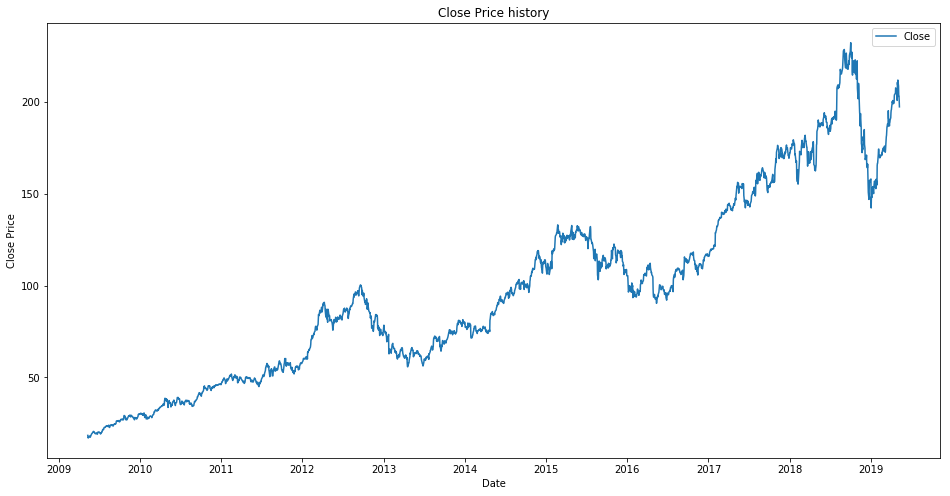

In [124]:
plotClosePriceByDate(data)

Moving Average Algorithm RMSE: 64.81345290436221


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


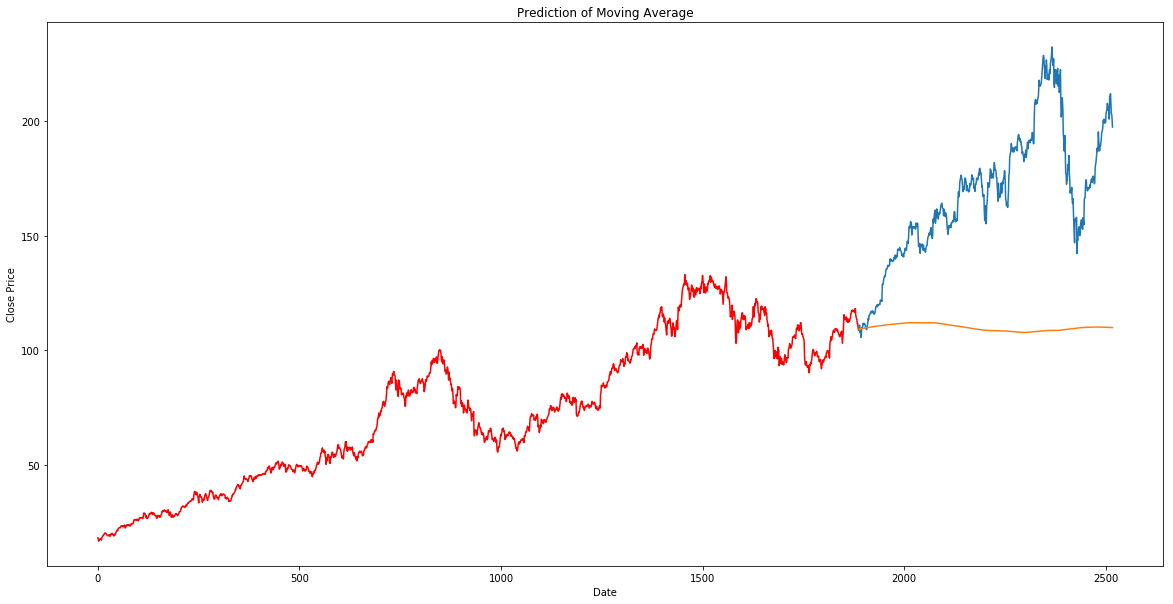

In [125]:
movingAverageAlgo(data)

In [0]:
arima(data)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 95s - loss: 6.1008e-04
LSTM: 4.747633154762507


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


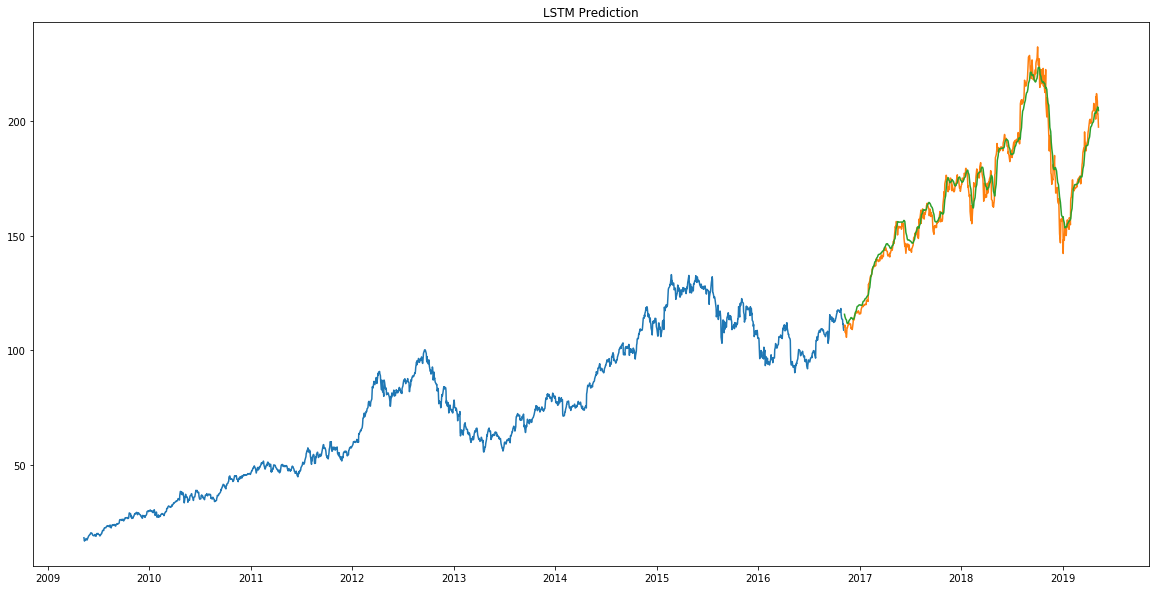

In [126]:
lstm(data)